<a href="https://colab.research.google.com/github/paulabarraza/Paula/blob/master/Desarrollo_Tarea_1_Web_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 Web Intelligence: Web Content Mining

El objetivo de esta tarea es que apliquen los conceptos vistos en las cátedras, en particular sobre el tópico de Web Content Mining y Machine Learning. Se espera que sigan los pasos del proceso KDD, es decir, selección de los datos, limpieza y preprocesamiento, transformación, data mining y evaluación, a la hora de resolver la problemática planteada.

La tarea tendrá 4 apartados, que tendrán que ir desarrollando de manera secuencial (no pueden hacer el apartado 2 sin haber hecho el 1).

Para trabajar libremente en su propio cuaderno de Colab, deben guardar una copia de este mismo cuaderno (Archivo --> Guardar una copia en Drive), y de esta manera tendrán la base de este documento y podrán ir editando sobre él.


## Sección 1: Web Scraper - Selección de datos

La primera parte de la tarea consiste en programar un *Web Scraper* que pueda recorrer distintos sitios web recogiendo información de dichos sitios. Esta información debe ser de tipo texto, para que puedan aplicar las técnicas de Web Content Mining. 

Existen distintas librerías de Python que permiten crear un Scraper como *Scrapy*, *Selenium* o *Beautiful Soup*.

En el siguiente enlace: [scraper](https://colab.research.google.com/drive/19N2NSOLHpjJtFlLxwT8Xd_XxS2sk69kj?usp=sharing), pueden encontrar un ejemplo de cómo se crea un Scraper utilizando la librería de Selenium. Dicho scraper recopila información de noticias del sitio web de CNN Chile. Las categorías de noticias que existen en CNN Chile son: 'País', 'Deportes', 'Mundo', 'Tendencias', 'Economía', 'Cultura' y 'Tecnologías'.

El resultado del Scraper implementado es un archivo JSON, que se puede cargar como base de datos utilizando la librería *Pandas* de Python con el siguiente enlace: https://github.com/josecantog/WI_DATA/raw/master/cnn_news.json.

Para efectos de la tarea, ustedes deben seleccionar otro sitio Web de noticias distinto al de CNN Chile para obtener los datos.

En esta primera parte del código se importan todas las librerías que se utilizarán para el resto de la tarea. En particular hay que tener cuidado con la primera celda, ya que esta requiere de un tratamiento especial. Lo primero que se debe hacer es correr esta celda que dice *!python -m spacy download es_core_news_md* y una vez que termine, se tiene que reiniciar el entorno de ejecución. Para esto último, van a las opciones que se encuentran en la esquina superior izquierda y seleccionan "Entorno de ejecución", y ahí seleccionan la opción "Reiniciar entorno de ejecución", y en la pestaña que se abre, ponen la opción "sí". Una vez finalizado lo anterior, puede proceder a correr todas las demás celdas del documento, desde la segunda (no se corre de nuevo la primera en donde aparece *!python -m spacy download es_core_news_md*).

In [212]:
!python -m spacy download es_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [213]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,876 kB]
Get:1

In [214]:

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common.exceptions import TimeoutException, ElementNotInteractableException, NoSuchElementException, StaleElementReferenceException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import numpy as np
import json
import time
import random
import urllib
import spacy
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Creación del scraper

In [221]:
#Introduzca su código aquí
urls = [
    'https://www.elmostrador.cl/noticias/pais/page/'
    #'https://www.elmostrador.cl/noticias/mundo/page/'
    #'https://www.elmostrador.cl/noticias/opinion/columnas/page/'
    #'https://www.elmostrador.cl/noticias/editorial/page/'
    #'https://www.elmostrador.cl/noticias/sin-editar/page/'
]
def links(url, categoria):

    print('Iniciando Scraper de la categoría:'+ categoria)
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    x = 2
    try:
        driver.get(url+str(x)+'/')
        data = []
        while True:
            elements = driver.find_elements_by_class_name('col-xs-7')
            for element in elements:
                link = element.find_elements_by_tag_name('a')[0]
                link = link.get_attribute('href')
                data.append(link)
                #print(link)
                if len(data)%100==0:
                    print('Se han encontrado'+str(len(data))+' links')
                if len(data) == 5:
                    break
            if len(data) == 5:
                    break
            x=x+1
            driver.get(url+str(x)+'/')
        driver.quit()
        print(len(data))
    except TimeoutException:
        print("Se excedió el tiempo de busqueda de un link")
    return data

def scraper(links, data):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    for link in links:
    

        try:
            driver.get(link)
            news = {}
            try:
                cuerpo = driver.find_element_by_class_name('cuerpo-noticia').find_elements_by_tag_name('p')
                contenido = ''
                try:
                    for item in cuerpo:
                        
                          string = item.get_attribute('innerHTML')
                          if len(item.find_elements_by_tag_name('a'))>0:
                              for body_tag in item.find_elements_by_tag_name('a'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),body_tag.get_attribute('innerHTML'))
                          if len(item.find_elements_by_tag_name('strong'))>0:
                              for body_tag in item.find_elements_by_tag_name('strong'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),body_tag.get_attribute('innerHTML'))
                          if len(item.find_elements_by_tag_name('span'))>0:
                              for body_tag in item.find_elements_by_tag_name('span'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),'')
                          if len(item.find_elements_by_tag_name('script'))>0:
                              for body_tag in item.find_elements_by_tag_name('script'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),'')
                          if len(item.find_elements_by_tag_name('img'))>0:
                              for body_tag in item.find_elements_by_tag_name('img'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),'')
                          if len(item.find_elements_by_tag_name('iframe'))>0:
                              for body_tag in item.find_elements_by_tag_name('iframe'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),'')
                          if len(item.find_elements_by_tag_name('div'))>0:
                              for body_tag in item.find_elements_by_tag_name('div'):
                                  string = string.replace(body_tag.get_attribute('outerHTML'),'')
                          if '&nbsp;' in string:
                              string = string.replace('&nbsp;','')
                          contenido = contenido +' '+string
                           
                except (StaleElementReferenceException, NoSuchElementException) as e:
                   print('Status:  Elemento no encontrado1  '+'   '+str(e))               

                listaClaves=driver.find_elements_by_class_name('tags-noticias')
                
                tags = []
                if len(listaClaves)>0:
                    claves=listaClaves[0].find_elements_by_tag_name('a')
                    for etiqueta in claves:
                      tags.append(etiqueta.get_attribute('innerText'))
                else:
                      tags = []

                #categoria = driver.find_element_by_class_name('heading-single').get_attribute('innerText')
                categoria = driver.find_element_by_class_name('col-md-8').find_elements_by_tag_name('a')[0].get_attribute('innerText')
              
                titulo = driver.find_element_by_class_name('titulo-single').get_attribute('innerText')
                #encabezado = driver.find_element_by_class_name('excerpt content-sm').get_attribute('innerHTML')


                news['categoria'] = categoria
                news['titulo'] = titulo
               # news['encabezado'] = encabezado
                news['contenido'] = contenido
                news['tags'] = tags
                data.append(news)
                if len(data)%4 == 0:
                    print('Se han Crawleado'+str(len(data))+' sitios distintos')
            except StaleElementReferenceException:
                pass
        except TimeoutException:
            pass
            if len(data)%10==0:
                secs = random.randint(30, 45)
                print('Waiting '+str(secs)+'seconds...')
                time.sleep(secs)
    driver.quit()
    #data = json.loads(data)
    return data   



In [ ]:
a=links('https://www.elmostrador.cl/noticias/editorial/page/','editorial')
scraper(a,[])


In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
driver.get('https://www.elmostrador.cl/destacado/2020/09/23/la-encrucijada-mortal-del-consejo-para-la-transparencia/')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


In [ ]:
driver.find_element_by_class_name('titulo-single').get_attribute('innerText')

In [223]:
def collect(urls, data):
    for url in urls:
        categoria = urllib.parse.urlparse(url).path.split('/')[-3]
        print(categoria)
        link = links(url,categoria)
        print("La cantidad de links a scrapear es:" + str(len(link)))
        data = scraper(link,data)
        
        secs = random.randint(1, 10)
        print('Waiting '+str(secs)+'seconds...')
        time.sleep(secs)
    
    #db = pd.DataFrame(data)
    #db.to_json(r'cnn_news.json')
    return data

 

In [225]:
Datos= []
database= collect(urls, Datos)
db = pd.DataFrame(database)

db.to_json(r'Datos_tarea1.json')

pais
Iniciando Scraper de la categoría:pais


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: use options instead of chrome_options
  app.launch_new_instance()


5
La cantidad de links a scrapear es:5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: use options instead of chrome_options


Se han Crawleado4 sitios distintos
Waiting 2seconds...


In [227]:
db

,categoria,titulo,contenido,tags
0,País,Por un voto: Senado rechaza por falta de quóru...,"No habrá ley. Este jueves, el Senado rechazó ...","[Gobierno, inhabilidades, proyecto, Senado]"
1,País,PDI detiene a madre de Ámbar Cornejo por su pa...,"Este jueves, la Brigada de Homicidios de la P...","[Ámbar Cornejo, Denisse Llanos, Madre]"
2,País,"""No existe irregularidad"": Intendenta de Coqui...","La cuarta región está consternada debido al ""...","[Coquimbo, Fisco, Fraude, Intendencia]"
3,País,Alcalde de Coyhaique culpa al Gobierno por ret...,Coyhaique vuelve a cuarentena a partir de est...,"[Coyhaique, cuarentena]"
4,País,Comisión revisora de acusación contra Mañalich...,La acusación constitucional contra el ex mini...,"[Acusación Constitucional, comisión, ivan flor..."


## Sección 2: Obtención del modelo Bag of Words

El segundo apartado de la tarea consiste en preparar los datos recopilados de la sección 1, para poder trabajar con estos y entrenar los modelos que se utilizarán.

Para esto, usted deberá obtener una representación *Bag of Words* de las distintas noticias recopiladas, siguiendo los pasos vistos en cátedras y auxiliares.

El resultado de esta sección debe ser dos bloques de código que permitan obtener esta representación para cualquiera de sus noticias recolectadas. La única diferencia entre un bloque y otro será que en uno utilizará, cuando corresponda, el proceso de Lematización y en el otro utilizará el proceso de Stemming.

In [ ]:
#Introduzca su código aquí (Lematización)

In [ ]:
#Introduzca su código aquí (Stemming)

## Sección 3: Obtención de TF-IDF

Para disponer de un vector de atributos representativo de cada noticia, usted debe obtener la representación TF-IDF asociada a cada documento. Para esto, le ofrecemos dos opciones:

1.- Utilizar la implementación de TF-IDF contenida en la librería *scikit-learn*, donde solo requerirá entregar las noticias en bruto: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

2.- (BONUS +1 punto) Basándose en el código utilizado para obtener la representación Bag of Words, implementar usted mism@ el código necesario para obtener la representación TF-IDF básica, como se vio en cátedra.

El resultado de esta sección debe ser un código que permita obtener esta representación para cualquiera de sus noticias recolectadas y que sirva como input para el código contenido en las celdas posteriores.

In [ ]:
#Introduzca su código aquí

In [ ]:
#Creamos los sets para entrenar el modelo.
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels,
                                                    train_size=0.8,
                                                    test_size=0.2, 
                                                    random_state=8)


# Sección 4a: Entrenar el modelo - Data mining

Una vez generado el vector de características, es decir, ya convertido en valores numéricos el contenido de las noticias, se procede a entrenar un modelo que permita clasificar una noticia de acuerdo a su contenido.

En este ejemplo se decide utilizar el modelo Randfom Forest, Support Vector Machine y K-Nearest Neighbour, en su versión básica, sin modificar ningún parámetro.

In [ ]:
#Se dejan los parámetros por defecto.
rfc = RandomForestClassifier(random_state=4)
svc =svm.SVC(random_state=8)
knnc =KNeighborsClassifier()

In [ ]:
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Accuracy de RFC')
print(accuracy_score(y_test,rfc_pred))

In [ ]:
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)
print('')
print('Accuracy SVM')
print(accuracy_score(y_test,svm_pred))

In [ ]:
knnc.fit(X_train, y_train)
knnc_pred = knnc.predict(X_test)
print('')
print('Accuracy KNN')
print(accuracy_score(y_test,knnc_pred))

# Sección 4b: Evaluación del modelo

Con el modelo ya entrenado, se procede a evaluar el desempeño de este. Para esto se utilizan métricas clásicas como 'Accuracy', y se graficará la matriz de confusión que permitirá visualizar que tan bien (o que tan mal) clasifica el modelo.

In [ ]:
# Classification report RFC
print("Classification report RFC")
print(classification_report(y_test, predictionsRFC))

In [ ]:
# Classification report SVM
print("Classification report SVM")
print(classification_report(y_test, svm_pred))

In [ ]:
# Classification report KNN
print("Classification report KNN")
print(classification_report(y_test, knnc_pred))

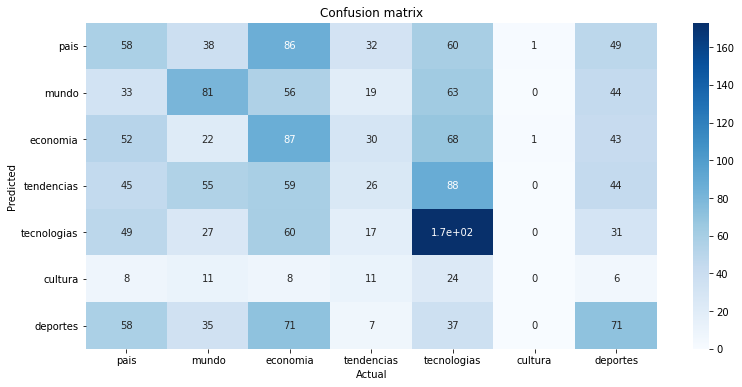

In [ ]:
#Matriz de confusión
aux_df = ds[['categoria', 'category_code']].drop_duplicates().sort_values('category_code')
conf_matrix = confusion_matrix(y_test1, predictionsRFC1)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['categoria'].values, 
            yticklabels=aux_df['categoria'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

# Entrega

El entregable de la tarea es un informe y el código que ustedes ejecuten en Google Colab.

El informe debe ser completamente autocontenido, por lo tanto debe tener un resumen ejecutivo, introducción, desarrollo del trabajo realizado, resultados obtenidos, discusión y conclusión. El informe puede tener como máximo 10 páginas, sin contar portada y anexos.

Para compartir el desarrollo realizado en Google Colab, deben poner la opción "compartir", luego seleccionar la opción de "obtener enlace", elegir que cualquier usuario con el link pueda comentar, y finalmente copiar el enlace generado y pegarlo en los comentarios de la entrega de la tarea en u-cursos.

La fecha de entrega es el domingo 4 de octubre a las 23:59.

## Recomendaciones

Debido a que los recursos de Google Colab y nuestros computadores son limitados, no se recomienda trabajar con bases muy grandes (miles de noticias) ya que el procesamiento de estos datos tomaría mucho tiempo y el fin de la tarea es que aprendan la lógica detrás de Web Content Mining y que su código corra (que no estén horas esperando a que su código termine de correr). Claro está, que con una base mayor los resultados también serán mejores, sin embargo, no se busca un resultado óptimo.

Lo mismo aplica para el largo de cada noticia, es decir, no se recomienda trabajar con noticias de muchos caracteres o muchas palabras, ya que estó hará que el procesamiento sea mayor, por lo que se les sugiere truncar las noticias, o configurar su Web Scraper para que incluya noticias que tengan un máximo de caracteres.